# Vehicle Detection Project

In this project, the goal is to write a software pipeline to detect vehicles in a video.

This project is using the Deep Learning algorithm called YOLO (v2).

**Please Note**: I have not used HOG+SVM for this project. However, I am fulfilling all the technical rubric points, just by aother method than HOG+SVM. I saw on the forum/slack that other students used other techniques, it was stated in the lesson that we were encouraged to experiment with other classifiers and my mentor said I could as long as I was clearly stating it and delivering a write up explaining my method.

References:
* [Yolo v2 paper](https://arxiv.org/abs/1612.08242)
* [Yolo v1 paper](https://arxiv.org/abs/1506.02640)
* [Yolo/Darknet website](https://pjreddie.com/darknet/yolo/)
* [Yolo/Darknet github](https://github.com/pjreddie/darknet)
* [YAD2K Keras/Tensorflow port](https://github.com/allanzelener/YAD2K)
* [Darkflow Tensorflow port](https://github.com/thtrieu/darkflow)

# Imports

In [1]:
import argparse
import imghdr
import os
import time

import cv2

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from IPython.display import HTML

from collections import deque

import numpy as np

from keras import backend as K
from keras.models import load_model
from keras.layers import Input

from yolo import yolo_eval, yolo_head, yolo_body

Using TensorFlow backend.


# Set

In [2]:
model_path = "model_data/yolo-voc.h5"
assert model_path.endswith('.h5'), 'Keras model must be a .h5 file.'
#weights_path = "model_data/yolo-voc.weights"
weights_path = "model_data/yolo-voc_weights.h5"
assert weights_path.endswith('weights.h5'), 'Keras model must be a .h5 file.'
anchors_path = "model_data/yolo-voc_anchors.txt"
classes_path = "model_data/voc_classes.txt"
test_path = "test_images"
output_path = "output_images"

if not os.path.exists(output_path):
    print('Creating output path {}'.format(output_path))
    os.mkdir(output_path)
    
with open(classes_path) as f:
    class_names = f.readlines()
class_names = [c.strip() for c in class_names]
num_classes = len(class_names)

with open(anchors_path) as f:
    anchors = f.readline()
    anchors = [float(x) for x in anchors.split(',')]
    anchors = np.array(anchors).reshape(-1, 2)
num_anchors = len(anchors)

# Utils

In [3]:
def draw_boxes(image, boxes, score, classes):  
    for i, box in enumerate(boxes):
            x1 = int(box[1])
            y1 = int(box[0])
            x2 = int(box[3])
            y2 = int(box[2])
            cv2.rectangle(image,(x1,y1),( x2,y2),(0,255,0),4)
            font = cv2.FONT_HERSHEY_SIMPLEX     
            cv2.putText(image, class_names[classes[i]] + ' - ' + str(int(score[i]*100)) ,(x1,y1-10), font, 1,(255,255,255),3)
    return image   

def draw_car_boxes(image, boxes, score, classes):  
    for i, box in enumerate(boxes):
        if class_names[classes[i]] == 'car':
            x1 = int(box[1])
            y1 = int(box[0])
            x2 = int(box[3])
            y2 = int(box[2])
            cv2.rectangle(image,(x1,y1),( x2,y2),(0,255,0),4)
            #font = cv2.FONT_HERSHEY_SIMPLEX     
            #cv2.putText(image, class_names[classes[i]] + ' - ' + str(int(score[i]*100)) ,(x1,y1-10), font, 1,(255,255,255),3)
    return image

In [4]:
def resize_image(image):
    if is_fixed_size:
        resized_image = cv2.resize(image, (model_image_size[::-1]), interpolation = cv2.INTER_CUBIC)
    else:
        # Due to skip connection + max pooling in YOLO_v2, inputs must have
        # width and height as multiples of 32.
        new_image_size = (image.shape[1] - (image.shape[1] % 32),
                          image.shape[0] - (image.shape[0] % 32))
        resized_image = cv2.resize(image, (new_image_size), interpolation = cv2.INTER_CUBIC)
    return resized_image

def normalize_image(image):
    image_data = np.array(image, dtype='float32')
    image_data /= 255.
    
    return image_data

def preprocess(image):
    resized_image = resize_image(image)
        
    image_data = normalize_image(resized_image)
    
    image_data = np.expand_dims(image_data, 0)  # Add batch dimension.

    return image_data

In [5]:
def remove_boxes_inside_another(boxes, scores, classes):
    indices = []
    nb_boxes = len(boxes)
    for i in range(nb_boxes):
        for j in range(i+1, nb_boxes):
            intersect_box = []
            intersect_box.append(max(boxes[i][0], boxes[j][0]))
            intersect_box.append(max(boxes[i][1], boxes[j][1]))
            intersect_box.append(min(boxes[i][2], boxes[j][2]))
            intersect_box.append(min(boxes[i][3], boxes[j][3]))
            
            if (intersect_box == list(boxes[i])):
                indices.append(i)
            if (intersect_box == list(boxes[j])):
                indices.append(j)
    if indices:
        print(indices)
        boxes = [v for i,v in enumerate(boxes) if i not in indices] 
        scores = [v for i,v in enumerate(scores) if i not in indices] 
        classes = [v for i,v in enumerate(classes) if i not in indices] 
        
    return boxes, scores, classes

In [6]:
def print_image(image):
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Yolo (v2) model

In [7]:
#inputs = Input(shape=(None, None, 3)) # TODO : not working
inputs = Input(shape=(416, 416, 3))
#inputs = Input(shape=(704, 704, 3))
yolo_model = yolo_body(inputs, num_anchors, num_classes)
yolo_model.load_weights(weights_path)

#yolo_model = load_model(model_path)

# Verify model, anchors, and classes are compatible
num_classes = len(class_names)
num_anchors = len(anchors)
# TODO: Assumes dim ordering is channel last
model_output_channels = yolo_model.layers[-1].output_shape[-1]
assert model_output_channels == num_anchors * (num_classes + 5), \
    'Mismatch between model and given anchor and class sizes. ' \
    'Specify matching anchors and classes with --anchors_path and ' \
    '--classes_path flags.'
print('{} model, anchors, and classes loaded.'.format(model_path))

# Check if model is fully convolutional, assuming channel last order.
model_image_size = yolo_model.layers[0].input_shape[1:3]
is_fixed_size = model_image_size != (None, None)

print(is_fixed_size)

yolo_model.summary()

model_data/yolo-voc.h5 model, anchors, and classes loaded.
True
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 416, 416, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 416, 416, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 416, 416, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 416, 416, 32) 0           batch_normalization_1[0][0]      
_____________________________________________

# Keras outputs and session

In [8]:
score_threshold = .6
iou_threshold = .3

# Generate output tensor targets for filtered bounding boxes.
yolo_outputs = yolo_head(yolo_model.output, anchors, num_classes)
input_image_shape = K.placeholder(shape=(2, ))
boxes, scores, classes = yolo_eval(
    yolo_outputs,
    input_image_shape,
    score_threshold=score_threshold,
    iou_threshold=iou_threshold)

sess = K.get_session()

# Execution

In [9]:
class Pipeline:
    def __init__(self):
        self.boxes = []
        self.history = deque(maxlen=8)
        self.first_frames = True
        self.i = 0

    def track(self, boxes):
        if len(boxes) == 0 and len(self.history) > 0:
            self.history.popleft()
        else:
            #create blank heatmap to store the most recent boxes
            heatmap = np.zeros([720,1280], np.int)
            for box in boxes:
                # Add += 1 for all pixels inside each box
                heatmap[int(box[0]):int(box[2]), int(box[1]):int(box[3])] += 1

            #add current heatmap to deque of heatmaps
            self.history.append(heatmap)

            #make sure to only use heatmap detection if there is enough information
            if len(self.history) > 4:
                self.first_frames = False
            else: 
                self.first_frames = True

            #add heatmaps together to make full heatmap
            if not self.first_frames:
                full_heatmap = np.zeros([720,1280], np.int)
                for preheat in self.history:
                    full_heatmap = np.add(full_heatmap, preheat)

                #if the center point of a box is not in an area the heatmap recognizes, remove that box
                new_boxes = []
                for box in boxes:
                    y = (box[0] + box[2]) / 2
                    x = (box[1] + box[3]) / 2
                    if full_heatmap[int(y), int(x)] > 2:
                        new_boxes.append(box)
                return new_boxes

        return boxes

    def pipeline(self, image):
        start = time.perf_counter()

        image_data = preprocess(image)

        out_boxes, out_scores, out_classes = sess.run(
            [boxes, scores, classes],
            feed_dict={
                yolo_model.input: image_data,
                input_image_shape: [image.shape[0], image.shape[1]],
                K.learning_phase(): 0
            })

        out_boxes, out_scores, out_classes = remove_boxes_inside_another(out_boxes, out_scores, out_classes)

        if tracking:
            out_boxes = self.track(out_boxes)

        if only_cars:
            detections_image = draw_car_boxes(image, out_boxes, out_scores, out_classes)
        else:
            detections_image = draw_boxes(image, out_boxes, out_scores, out_classes)

        if cv_display:
            frame_rgb = cv2.cvtColor(detections_image, cv2.COLOR_BGR2RGB)
            cv2.imshow('frame', frame_rgb)
            cv2.waitKey(1)

        if print_info:
            elapsed = time.perf_counter() - start
            print('Found {} boxes'.format(len(out_boxes)))
            print('Elapsed: %.3f seconds.' % elapsed)

        self.i += 1

        return detections_image

## Test images

Found 2 boxes
Elapsed: 1.373 seconds.


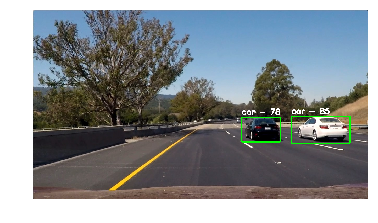

Found 0 boxes
Elapsed: 0.053 seconds.


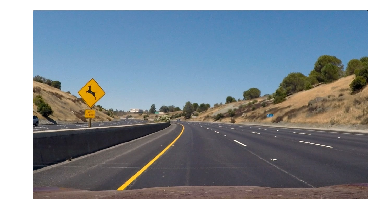

Found 2 boxes
Elapsed: 0.045 seconds.


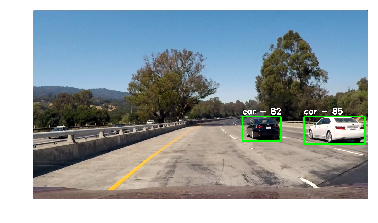

Found 1 boxes
Elapsed: 0.040 seconds.


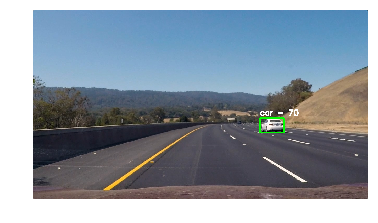

Found 2 boxes
Elapsed: 0.038 seconds.


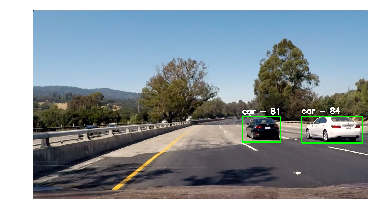

Found 2 boxes
Elapsed: 0.035 seconds.


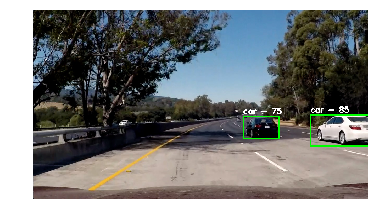

Total elapsed with initialization:7.981 seconds.
FPS: 0.752


In [10]:
only_cars = False
cv_display = False
print_info = True
tracking = False

total_start = time.perf_counter()

pipe = Pipeline()

for image_file in os.listdir(test_path):
    full_path = os.path.join(test_path, image_file)
    
    try:
        image_type = imghdr.what(full_path)
        if not image_type:
            continue
    except IsADirectoryError:
        continue

    image = mpimg.imread(os.path.join(test_path, image_file))
    
    result_image = pipe.pipeline(image)
    
    print_image(result_image)
    
    png_path = os.path.splitext(image_file)[0]+'.png'
    full_png_path = os.path.join(output_path, png_path)
    plt.imsave(full_png_path, result_image)
    
total_elapsed = time.perf_counter() - total_start
print('Total elapsed with initialization:%.3f seconds.' % total_elapsed)
print('FPS: %.3f' % (float(pipe.i) / float(total_elapsed)))

## Video

### Matplotlib version

In [11]:
from moviepy.editor import VideoFileClip

only_cars = True
cv_display = False
print_info = False
tracking = True

pipe = Pipeline()

total_start = time.perf_counter()

output = 'result_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
result_clip = clip1.fl_image(pipe.pipeline)
%time result_clip.write_videofile(output, audio=False)

total_elapsed = time.perf_counter() - total_start
print('Total elapsed: %.3f seconds.' % total_elapsed)
print('FPS: %.3f' % (float(pipe.i) / float(total_elapsed)))

[MoviePy] >>>> Building video result_video.mp4
[MoviePy] Writing video result_video.mp4


100%|█████████▉| 1260/1261 [01:36<00:00, 12.99it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result_video.mp4 

CPU times: user 58 s, sys: 6.35 s, total: 1min 4s
Wall time: 1min 37s
Total elapsed: 97.777 seconds.
FPS: 12.897


### OpenCV version

In [17]:
only_cars = True
cv_display = False
save_video = True
print_info = False
tracking = True

pipe = Pipeline()

cap = cv2.VideoCapture('project_video.mp4')

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'H264')
out = cv2.VideoWriter('result_video_opencv.mp4',fourcc, 25.0, (1280,720))

total_start = time.perf_counter()

while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == False:
        break

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB);
        
    detections_frame = pipe.pipeline(frame_rgb)
    
    detections_frame_bgr = cv2.cvtColor(detections_frame, cv2.COLOR_BGR2RGB);
    
    if save_video:
        out.write(detections_frame_bgr)

total_elapsed = time.perf_counter() - total_start
print('Total elapsed: %.3f seconds.' % total_elapsed)
print('FPS: %.3f' % (float(pipe.i) / float(total_elapsed)))
        
out.release()
cap.release()
cv2.destroyAllWindows()

Total elapsed: 91.921 seconds.
FPS: 13.544


### Display video result

In [18]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))